In [23]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy
from matplotlib.gridspec import GridSpec
import datetime
import warnings
import tqdm
from metpy import calc
import string
from metpy.units import units

(c1,c2,c3,c4)=('#1b9e77','#d95f02','#7570b3','#e7298a')
warnings.simplefilter("ignore")
names = ['High Cloud','Low Cloud','Clear Sky']

# Import data

In [2]:
# met_dict = pickle.load(open('met_dict.p','rb'))
rawinsondes = pickle.load(open('../rawinsondes.p','rb'))

In [13]:
df = pickle.load(open('big_df.p','rb'))

df['hour'] = [d.time().hour for d in df['dt']]
df = df[df['hour']==9]

print(df.shape)

(12794, 24)


In [14]:
list_of_dicts = []
bad_codes = []

for dt, NP, code in zip(df['dt'],df['NP'],df.index):
    
#     print(code)
    
    if (NP in rawinsondes.keys()) and (dt.date() in rawinsondes[NP].keys()):
#         print(code)
        rs_metadata = rawinsondes[NP][dt.date()]['metadata']
        rs_metadata['code'] = code
        list_of_dicts.append(rs_metadata)
            
    else:
        bad_codes.append(code)

df_meta = pd.DataFrame(list_of_dicts)

df_meta.set_index('code',inplace=True)

for code in tqdm.tqdm(bad_codes):
    df = df[df.index!=code]

df = pd.concat([df,df_meta],axis=1)

df

100%|██████████████████████████████████████| 4956/4956 [00:05<00:00, 852.57it/s]


,Latitude,Longitude,Air temperature,Relative humidity,Sea level pressure,Wind direction,Wind speed,Total cloudiness,Low cloudiness,Surface temperature,...,CLOUD_HEIGHT_QLTY,MID_CLOUD,MID_CLOUD_QLTY,HIGH_CLOUD,HIGH_CLOUD_QLTY,date,n_points,inversion_depth,inversion_temperature,precipitable_water
code,,,,,,,,,,,,,,,,,,,,,
1954-09-01 09:00:00_03,89.452,-110.724,-4.6,90.0,1018.6,20.0,5.0,8.0,0.0,-6.0,...,-9,-9,-9,-9,-9,1954-09-01,14,200.0,-4.6,9.103769
1954-09-02 09:00:00_03,89.454,-106.078,-1.2,99.0,1023.1,315.0,2.0,10.0,10.0,-2.0,...,-9,-9,-9,-9,-9,1954-09-02,15,NaN,NaN,NaN
1954-09-03 09:00:00_03,89.453,-101.419,-1.8,92.0,1022.4,250.0,4.0,10.0,0.0,-2.0,...,-9,-9,-9,-9,-9,1954-09-03,16,NaN,NaN,NaN
1954-09-04 09:00:00_03,89.449,-96.809,-2.8,98.0,1023.0,0.0,0.0,10.0,3.0,-3.0,...,-9,-9,-9,-9,-9,1954-09-04,4,170.0,-2.3,7.712338
1954-09-05 09:00:00_03,89.440,-92.305,-2.0,96.0,1017.6,160.0,6.0,10.0,0.0,-2.0,...,-9,-9,-9,-9,-9,1954-09-05,17,380.0,0.4,10.103701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990-04-26 09:00:00_31,76.233,-134.446,-11.2,88.0,1005.6,180.0,11.0,10.0,0.0,-12.0,...,9,0,4,0,0,1990-04-26,11,575.0,-3.1,8.926267
1990-04-27 09:00:00_31,76.280,-134.106,-16.0,84.0,1006.8,305.0,8.0,7.0,0.0,-17.0,...,9,0,0,0,0,1990-04-27,10,660.0,-15.7,8.926267
1990-04-28 09:00:00_31,76.272,-133.984,-18.9,85.0,1020.8,250.0,8.0,2.0,0.0,-20.0,...,9,0,0,0,0,1990-04-28,10,958.0,-11.5,8.926267


In [15]:
def get_pw(m,bottom=None,top=None):

    temperature_metpy = np.array(m['temperature'])*units.degC
    humidity_metpy = np.array(m['humidity'])*units.percent
    dewpoint_metpy = calc.dewpoint_from_relative_humidity(temperature_metpy,humidity_metpy)
    pressure_metpy = np.array(m['pressure'])*units.hPa
    
    precipitable_water_metpy = calc.precipitable_water(pressure_metpy,dewpoint_metpy,bottom=bottom,top=top)
    
#     plt.plot(precipitable_water_metpy,m['altitude'])
    
    return precipitable_water_metpy

def get_esat_i(data):
    exp = np.exp((22.452*data['temperature'])/(272.55+data['temperature']))
    coeff = (1.0003+(4.18e-6*data['pressure']))*6.1115
    return exp*coeff

def get_esat_w(data):
    exp = np.exp((17.966*data['temperature'])/(247.15+data['temperature']))
    coeff = (1.0007+(3.46e-6*data['pressure']))*6.1121
    return exp*coeff

def get_rhi(data):
    ei = get_esat_i(data)
    ew = get_esat_w(data)
    rhi = ew*data['humidity']/ei
    return rhi
    
def interp(df, new_index):
    """Return a new DataFrame with all columns values interpolated
    to the new_index values."""
    
#     try:
#         df.set_index('altitude')
#     except:
#         pass
    
    df_out = pd.DataFrame(index=new_index)
    df_out.index.name = df.index.name

    for colname, col in df.iteritems():
        df_out[colname] = np.interp(new_index, df.index, col)

    return df_out

In [17]:
weather_vars = ['temperature','humidity','dewpoint','rh_i']

x = {'altitude':{}, 
     'pw_high':{},
     'pw_low':{},
     'pw_tot':{},
     'rhi_high_max':{},
     'rhi_low_max':{},
     'rhi_tot_mean':{},
         'code':{},
         'diff':{}}

a, b = 0, 0

for var in weather_vars:
    x[var] = {}

name = 'Low Cloud'

codes = []

for d in [df]:
    
    for key in x.keys():
        x[key][name] = []
        
    
    
    for i in tqdm.tqdm(d.index):

        if d.loc[i]['n_points'] > 10:
            if d.loc[i]['min_altitude'] < 50:
                if d.loc[i]['max_altitude'] > 8000:


                    NP = d.loc[i]['NP']

                    data =  rawinsondes[NP][df['date'].loc[i]]['data']


                    pw = rawinsondes[NP][df['date'].loc[i]]['metadata']['precipitable_water']

                    data = data[data['humidity']<100]
                    data = data[data['humidity']>0]
                    data = data[data['altitude']>=0]
                    
                    try:
                        max_2000 = np.nanmax(data['temperature'][data['altitude']>2000])
                        min_2000 = np.nanmin(data['temperature'][data['altitude']<2000])

    #                     print(max_2000,min_2000)
    #                     plt.plot(data['temperature'],data['altitude'],marker='o')
    #                     plt.axhline(2000)
    #                     plt.ylim(0,3000)
    #                     plt.show()

                        if max_2000>min_2000:
                            # Then the coldest temperature above 2000m is warmer than the warmest temp below 2000m
                            a+=1
                        b+=1

                        data['rh_i'] = get_rhi(data)

                        d_ = data.copy()

                        d_.set_index('altitude',inplace=True)


                        codes.append(i)
                    except:
                        pass

100%|██████████████████████████████████████| 7838/7838 [00:14<00:00, 551.02it/s]


In [36]:
df = df[np.isin(df.index,codes)]

df = df.loc[:,~df.columns.duplicated()].copy()

df_night = df[df['zenith']>90]
df_day = df[df['zenith']<90]

print(df_night.shape[0]/(df_day.shape[0]+df_night.shape[0]))

day = []
night = []

for month in np.arange(1,13):
    
    day.append( df_day[df_day['month']==month].shape[0] )
    night.append( df_night[df_night['month']==month].shape[0] )

0.8842276422764228


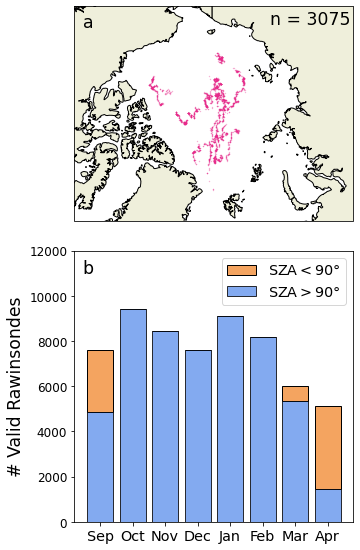

In [43]:
fig = plt.figure(figsize=(5,10))


ax1 = plt.subplot(2,1,1,projection=ccrs.NorthPolarStereo())
ax2 = plt.subplot(2,1,2)

ax1.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

ax1.set_extent([-2.633e+06, 2.696e+06, -1.5e6, 2.6e+06], crs=ccrs.NorthPolarStereo()) 

ax1.scatter(df['Longitude'],df['Latitude'],
            transform=ccrs.PlateCarree(),
            zorder=0,
            s=0.1,
            alpha=0.5,
            color=c4
            )

ax1.annotate(f'a',
             xycoords='axes fraction',
             xy=(0.03,0.97),
             va='top',
             fontsize='xx-large')


ax1.annotate(f'n = {df.shape[0]}',
             xycoords='axes fraction',
             xy=(0.99,0.98),
             va='top',
             ha='right',
             fontsize='xx-large')


#### AX2

ax2.bar(np.arange(8),day[8:]+day[:4],bottom=night[8:]+night[:4],
        label='SZA$<$90$\degree$',color='sandybrown',edgecolor='k')
ax2.bar(np.arange(8),night[8:]+night[:4],color='cornflowerblue',
        label='SZA$>$90$\degree$',alpha=0.8,edgecolor='k')
ax2.legend(fontsize='x-large')
ax2.set_xticks(range(8))
ax2.set_xticklabels(['Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr'],fontsize='x-large')
ax2.set_ylim(0,600)
ax2.set_ylabel('# Valid Rawinsondes',fontsize='xx-large')
ax2.set_yticklabels(np.arange(0,16001,2000),fontsize='large')


ax2.annotate(f'b',
             xycoords='axes fraction',
             xy=(0.03,0.97),
             va='top',
             fontsize='xx-large')


plt.subplots_adjust(hspace=0.005)


plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/Inversion/supp_figs/rsonde_map.png',
            dpi=400,
            bbox_inches='tight')

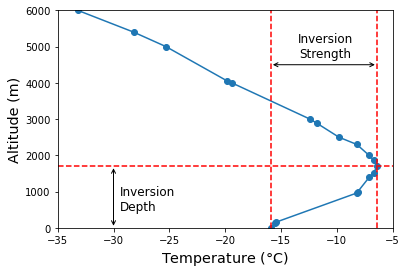

In [114]:
i = '1954-09-30 09:00:00_03'

data =  rawinsondes['03'][df['date'].loc[i]]['data']


fig, ax = plt.subplots(1,1,figsize=(6,4))

plt.plot(data['temperature'],data['altitude'],marker='o',markersize=6)
plt.ylim(0,6000)
plt.xlim(-35,-5)


plt.axvline(data['temperature'][np.argmin(data['altitude'])],color='r',ls='--')
plt.axvline(np.max(data['temperature']),color='r',ls='--')

plt.axhline(data['altitude'][10],color='r',ls='--')

x = -30

plt.annotate(xy=(x,0), xytext=(x,data['altitude'][10]),
             arrowprops=dict(arrowstyle='<->'),xycoords='data',
             text='')

y = 4500

plt.annotate(xy=(data['temperature'][np.argmin(data['altitude'])],y), xytext=(np.max(data['temperature']),y),
             arrowprops=dict(arrowstyle='<->'),xycoords='data',
             text='')


plt.annotate(xy=(-29.4,800),xycoords='data',fontsize='large',ha='left',va='center',
             text='Inversion\nDepth')

plt.annotate(xy=(-11,5000),xycoords='data',fontsize='large',ha='center',va='center',
             text='Inversion\nStrength')

plt.ylabel('Altitude (m)',fontsize='x-large')
plt.xlabel(r'Temperature ($\degree$C)',fontsize='x-large')


plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/Inversion/supp_figs/rsonde_schematic.png',
            dpi=400,
            bbox_inches='tight')

plt.show()